# Dataset retirado do Kaggle

## Setup

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

## Limpeza inicial

Começaremos realizando a leitura do arquivo, utilizando a biblioteca `pandas`.

In [78]:
# Arquivo retirado de https://www.kaggle.com/datasets/realkiller69/gaia-stars-dataset-from-dr3-data-release-3
nome_arquivo = "C:\\Users\\Marcelo\\Downloads\\dataGaia2.csv"
df = pd.read_csv(nome_arquivo)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626016 entries, 0 to 626015
Data columns (total 50 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  626016 non-null  int64  
 1   RA_ICRS     626016 non-null  float64
 2   DE_ICRS     626016 non-null  float64
 3   Source      626016 non-null  int64  
 4   e_RA_ICRS   626016 non-null  float64
 5   e_DE_ICRS   626016 non-null  float64
 6   Plx         626016 non-null  float64
 7   e_Plx       626016 non-null  float64
 8   PM          626016 non-null  float64
 9   pmRA        626016 non-null  float64
 10  e_pmRA      626016 non-null  float64
 11  pmDE        626016 non-null  float64
 12  e_pmDE      626016 non-null  float64
 13  RUWE        626016 non-null  float64
 14  Gmag        626015 non-null  float64
 15  e_Gmag      626015 non-null  float64
 16  BPmag       626015 non-null  float64
 17  e_BPmag     626015 non-null  float64
 18  RPmag       626016 non-null  float64
 19  e_

O arquivo inicial possui mais de 230 MB. Para reduzir o espaço utilizado, assim como a memória, iniciaremos removendo algumas colunas.

In [79]:
# Seleção de colunas relevantes
colunas = [
    "E(BP-RP)",    # cor da estrela
    "GMAG",        # magnitude absoluta
    "Teff",        # temperatura efetiva
    "Dist",        # distância
    "SpType-ELS",  # classe espectral
    "Lum-Flame",   # luminosidade
    "Mass-Flame",  # massa
    "Age-Flame",   # idade
    "Rad",         # raio da estrela
    "PWD",         # probabilidade de ser uma anã branca
    "Pstar",       # probabilidade de ser uma estrela (sem ser anã branca)
    "PGal",        # probabilidade de ser uma galáxia
    "Plx",
    "e_Gmag",
    "e_BPmag",
    "e_RPmag",
    "AG"
]

df["BP-RP"] = df["BPmag"] - df["RPmag"]
df["BP-RP_corr"] = df["BP-RP"] - df["E(BP-RP)"]
df = df.dropna(subset=["BPmag", "RPmag"])
colunas.append("BP-RP_corr")

df = df[colunas]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 626015 entries, 0 to 626015
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   E(BP-RP)    626015 non-null  float64
 1   GMAG        626015 non-null  float64
 2   Teff        626015 non-null  float64
 3   Dist        626015 non-null  float64
 4   SpType-ELS  626015 non-null  object 
 5   Lum-Flame   611292 non-null  float64
 6   Mass-Flame  590795 non-null  float64
 7   Age-Flame   544680 non-null  float64
 8   Rad         626015 non-null  float64
 9   PWD         626015 non-null  float64
 10  Pstar       626015 non-null  float64
 11  PGal        626015 non-null  float64
 12  Plx         626015 non-null  float64
 13  e_Gmag      626015 non-null  float64
 14  e_BPmag     626015 non-null  float64
 15  e_RPmag     626015 non-null  float64
 16  AG          626015 non-null  float64
 17  BP-RP_corr  626015 non-null  float64
dtypes: float64(17), object(1)
memory usage: 90.7+ MB


In [80]:
df.describe()

,E(BP-RP),GMAG,Teff,Dist,Lum-Flame,Mass-Flame,Age-Flame,Rad,PWD,Pstar,PGal,Plx,e_Gmag,e_BPmag,e_RPmag,AG,BP-RP_corr
count,626015.000000,626015.000000,626015.000000,626015.000000,611292.000000,590795.000000,544680.000000,626015.000000,626015.000000,626015.000000,626015.000000,626015.000000,626015.000000,626015.000000,626015.000000,626015.000000,626015.000000
mean,0.624456,2.232903,7295.089104,2150.402346,114.627988,1.841870,3.776441,8.030583,0.010132,0.971183,0.000003,1.466433,0.002857,0.004335,0.004406,1.134366,0.677839
std,0.598189,2.697245,3769.970949,3216.575605,330.115281,1.004918,4.139874,27.666631,0.099455,0.166293,0.000547,2.015174,0.000566,0.004819,0.002519,1.060195,0.647212
min,0.000000,-7.961700,3039.229700,10.519300,0.034732,0.500000,0.200000,0.345400,0.000000,0.000001,0.000000,-5.014100,0.002757,0.002794,0.003781,0.000000,-1.174750
25%,0.219600,0.340400,5217.458000,586.924150,2.066951,1.041000,0.524000,1.345000,0.000000,0.999915,0.000000,0.313100,0.002765,0.002917,0.003819,0.401300,0.129491
50%,0.417200,1.979300,5957.610400,1104.664800,11.679543,1.649000,1.448000,2.056100,0.000000,0.999976,0.000000,0.850400,0.002772,0.003126,0.003875,0.770100,0.719116
75%,0.877200,3.919600,8391.985000,2607.730750,60.254360,2.462000,6.629000,4.007600,0.000000,0.999995,0.000000,1.633600,0.002796,0.003812,0.004012,1.611000,0.967513
max,4.116100,9.963000,41504.020000,35666.805000,3499.921000,7.521000,13.500000,1105.995600,0.999950,1.000000,0.308608,95.047700,0.065528,0.323298,0.179498,7.185600,3.961059


A filtragem realizada considerará que:
- O objeto observado deve ter baixa probabilidade de ser uma galáxia (`Pgal < 0.1`)
- O objeto deve ter alta probabilidade de ser uma estrela padrão ou de ser uma anã branca (`Pstar > 0.9` ou `PWD > 0.9`)
- A paralaxe do objeto seve ser positiva (`Plx > 0`)
- Os erros fotométricos devem ser baixos (`e_Gmag < 0.05; e_BPmag, e_RPmag < 0.1`)
- A imagem deve ter baixa extinção (`AG < 0.5`)

In [81]:
# Objetos adequados em probabilidade
df = df[((df['Pstar'] > 0.9) | (df['PWD'] > 0.9)) & (df['PGal'] < 0.1)]

# Paralaxe positiva
df = df[df['Plx'] > 0]

# Remoção de erros fotométricos grandes
df = df[df['e_Gmag'] < 0.05]
df = df[df['e_BPmag'] < 0.1]
df = df[df['e_RPmag'] < 0.1]

# Remoção de alta extinção
# df = df[df['AG'] < 0.5]

df.describe()

,E(BP-RP),GMAG,Teff,Dist,Lum-Flame,Mass-Flame,Age-Flame,Rad,PWD,Pstar,PGal,Plx,e_Gmag,e_BPmag,e_RPmag,AG,BP-RP_corr
count,607296.000000,607296.000000,607296.000000,607296.000000,599212.000000,579143.000000,533305.000000,607296.000000,607296.000000,607296.000000,6.072960e+05,607296.000000,607296.000000,607296.000000,607296.000000,607296.000000,607296.000000
mean,0.628186,2.190044,7197.129459,2047.584745,115.465143,1.857988,3.690601,8.169333,0.008583,0.991057,4.079264e-07,1.397925,0.002850,0.004263,0.004347,1.141624,0.672532
std,0.596542,2.614755,3440.079388,2847.507106,330.281028,0.999014,4.073448,27.976766,0.092125,0.092345,7.392799e-05,1.880071,0.000485,0.004370,0.002210,1.057106,0.630466
min,0.000000,-7.961700,3178.567000,10.519300,0.034732,0.500000,0.200000,0.345400,0.000000,0.000048,0.000000e+00,0.000100,0.002757,0.002794,0.003781,0.000000,-1.174750
25%,0.220200,0.351900,5246.064475,603.789675,2.172170,1.051000,0.512000,1.364100,0.000000,0.999923,0.000000e+00,0.318600,0.002765,0.002914,0.003819,0.403100,0.159962
50%,0.423900,1.972000,5956.858150,1110.963000,12.194317,1.664000,1.382000,2.075600,0.000000,0.999977,0.000000e+00,0.845300,0.002772,0.003115,0.003873,0.782400,0.719322
75%,0.884200,3.883300,8232.784500,2578.258300,61.244224,2.479000,6.385000,4.056925,0.000000,0.999995,0.000000e+00,1.585900,0.002794,0.003754,0.004004,1.623700,0.956241
max,4.114700,9.963000,41504.020000,35666.805000,3499.921000,7.521000,13.500000,1105.995600,0.999950,1.000000,3.746290e-02,95.047700,0.027048,0.099726,0.092315,7.185600,3.961059


Note que existem linhas com os valores `SpType-ELS`, `Lum-Flame` e `Mass-Flame` vazios. 

Como o dataset possui centenas de milhares de objetos, e a remoção de dados não deve prejudicar a análise, inicialmente as linhas com dados incompletos podem ser removidas. Porém, há um viés que será observado posteriormente para as anãs brancas, e por isso, a remoção não será realizada.

A fim de reduzir o tamanho do arquivo e reduzir o tempo necessário para as análises, será utilizado um subconjunto dos dados filtrados, escolhido aleatoriamente.

In [82]:
df_sample = df.sample(n=100000, random_state=67)
df_sample.describe()

,E(BP-RP),GMAG,Teff,Dist,Lum-Flame,Mass-Flame,Age-Flame,Rad,PWD,Pstar,PGal,Plx,e_Gmag,e_BPmag,e_RPmag,AG,BP-RP_corr
count,100000.000000,100000.000000,100000.000000,100000.000000,98723.000000,95457.000000,87980.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.626447,2.210915,7184.134984,2029.697624,113.410721,1.850469,3.701246,8.045610,0.008372,0.991262,3.050319e-07,1.399964,0.002848,0.004241,0.004334,1.138440,0.672478
std,0.593936,2.612850,3415.003033,2814.523654,326.420466,0.993250,4.084046,27.653692,0.090965,0.091238,4.265071e-05,1.854585,0.000465,0.004267,0.002141,1.052551,0.628580
min,0.000000,-7.474600,3194.589400,13.125100,0.035363,0.501000,0.200000,0.387300,0.000000,0.000048,0.000000e+00,0.000100,0.002757,0.002795,0.003781,0.000000,-0.676305
25%,0.219700,0.369650,5250.886925,600.770900,2.133887,1.048000,0.513000,1.354375,0.000000,0.999923,0.000000e+00,0.321300,0.002765,0.002914,0.003819,0.401800,0.166240
50%,0.423800,1.993100,5958.196050,1102.118650,12.024175,1.659000,1.392000,2.060400,0.000000,0.999977,0.000000e+00,0.851000,0.002772,0.003114,0.003873,0.781900,0.718869
75%,0.880900,3.907700,8201.053000,2557.473300,59.958641,2.463000,6.408000,4.009075,0.000000,0.999995,0.000000e+00,1.594025,0.002794,0.003745,0.004002,1.618825,0.954634
max,4.044300,9.429300,41482.332000,34784.030000,3490.348900,7.448000,13.500000,975.109200,0.999950,1.000000,9.750960e-03,76.261500,0.022615,0.099726,0.086532,7.063600,3.942472


Abaixo, é possível observar que as candidatas a serem anãs brancas no sample, em geral, não possuem estimativas de idade (`Age-Flame`), e mesmo estimativas de massa não são tão frequentes. Por isso, descartar linhas incompletas pode distorcer o dataset original, assim justificando mantê-las.

In [83]:
df_wa = df_sample[df_sample['PWD'] > 0.9]
df_wa.describe()

,E(BP-RP),GMAG,Teff,Dist,Lum-Flame,Mass-Flame,Age-Flame,Rad,PWD,Pstar,PGal,Plx,e_Gmag,e_BPmag,e_RPmag,AG,BP-RP_corr
count,840.000000,840.000000,840.000000,840.000000,546.000000,49.000000,0.0,840.000000,840.000000,840.000000,8.400000e+02,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000
mean,0.220901,-0.431882,19749.908726,17713.177669,412.644682,6.228082,NaN,2.725759,0.996609,0.000053,2.676163e-05,0.313513,0.002989,0.006124,0.009262,0.407678,-0.344823
std,0.265275,1.406842,4416.044794,7808.458085,560.624296,0.729931,NaN,2.403552,0.013336,0.000012,3.894184e-04,0.311307,0.000498,0.003772,0.005603,0.488218,0.086388
min,0.000000,-6.591700,9995.203000,161.200900,0.352486,4.497000,NaN,0.966700,0.900039,0.000048,0.000000e+00,0.000500,0.002764,0.002812,0.003784,0.000100,-0.605973
25%,0.002100,-1.065450,16804.635500,13027.149500,103.028046,5.821000,NaN,1.628525,0.999947,0.000050,0.000000e+00,0.172775,0.002839,0.003865,0.005211,0.004000,-0.408998
50%,0.082150,0.011450,19227.093000,17926.813000,250.228115,6.358000,NaN,1.865600,0.999949,0.000050,2.000000e-08,0.300000,0.002900,0.005126,0.007927,0.153600,-0.341776
75%,0.410050,0.536425,21186.913500,22824.829500,478.181135,6.801000,NaN,2.660275,0.999950,0.000050,3.400000e-07,0.403200,0.002985,0.007061,0.011324,0.756400,-0.286851
max,1.037800,2.732200,39822.598000,34784.030000,3256.654000,7.308000,NaN,38.139800,0.999950,0.000143,9.750960e-03,6.816800,0.011369,0.036446,0.047829,1.900800,-0.038200


## Diagrama HR inicial

Com base nos dados de temperatura efetiva (`Teff`) e luminosidade (relacionada à magnitude absoluta `GMAG`), podemos criar uma primeira versão para o diagrama HR.

Como o valor de magnitude absoluta é menor para estrelas mais luminosas, é necessário inverter o eixo Y. O mesmo ocorre para a temperatura efetiva, geralmente apresentada de forma decrescente no diagrama, gerando a necessidade de inverter também o eixo X.

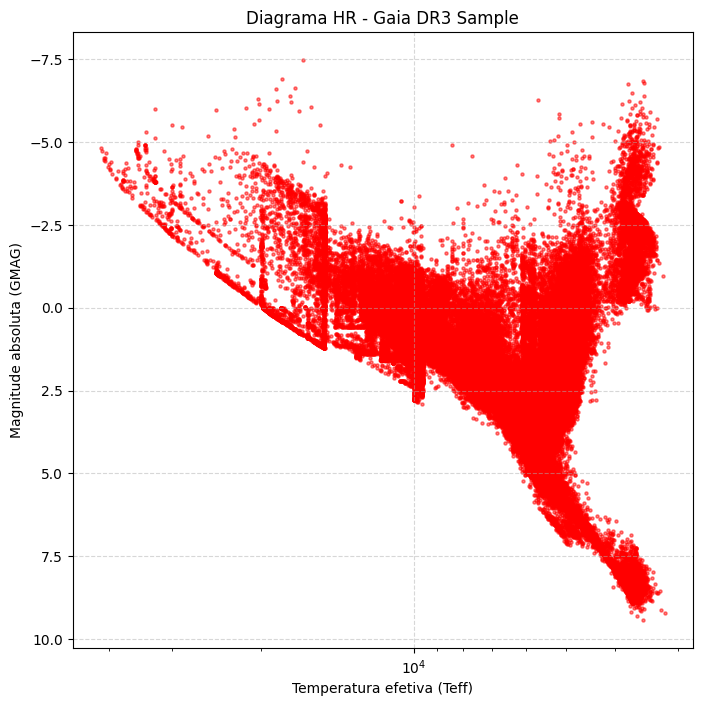

In [84]:
plt.figure(figsize=(8, 8))

plt.scatter(df_sample["Teff"], df_sample["GMAG"],
            s=5, color='red', alpha=0.5)

# Inversão dos eixos X e Y
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

# Escala logarítmica para a temperatura efetiva
plt.xscale('log')

plt.xlabel("Temperatura efetiva (Teff)")
plt.ylabel("Magnitude absoluta (GMAG)")
plt.title("Diagrama HR - Gaia DR3 Sample")

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

O parâmetro GMAG é obtido considerando a distância até a estrela. Para estrelas pequenas, como anãs brancas, o valor estimado pode ser mais baixo, pois o raio é pequeno, dando a impressão de que são mais luminosas.

O diagrama abaixo mostra que a métrica `Lum-Flame`, que representa a luminosidade em múltiplos da luminosidade solar, é mais adequada para identificar estrelas. As candidatas a anã branca, com probabilidade acima de 90%, estão marcadas em ciano. Parece haver ruído nas temperaturas efetivas mais altas, o que também ocorre para anãs brancas que parecem estar em cima da sequência principal.

Esse ruído elevado tem uma interpretação física. Para estrelas de altas temperaturas, incertezas na medição do raio causam grandes variações de luminosidade, pois ela é proporcional a $R^2T_{eff}^4$. Além disso, o aumento de emissão no espectro UV, que não é detectado pelo Gaia, faz com que haja mais incerteza sobre a luminosidade.

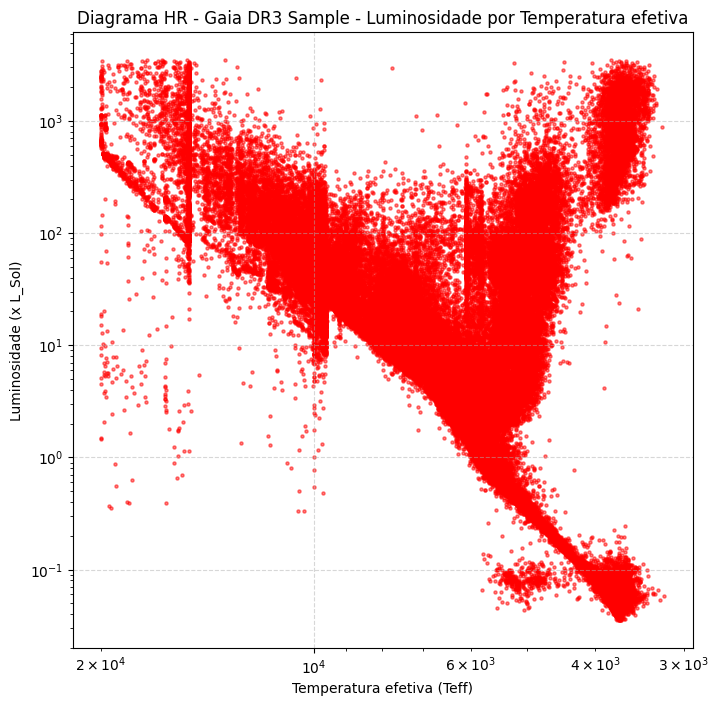

In [85]:
plt.figure(figsize=(8, 8))

plt.scatter(df_sample["Teff"], df_sample["Lum-Flame"],
            s=5, color='red', alpha=0.5)

plt.gca().invert_xaxis()

plt.xscale('log')
plt.yscale('log')

plt.xlabel("Temperatura efetiva (Teff)")
plt.ylabel("Luminosidade (x L_Sol)")
plt.title("Diagrama HR - Gaia DR3 Sample - Luminosidade por Temperatura efetiva")

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

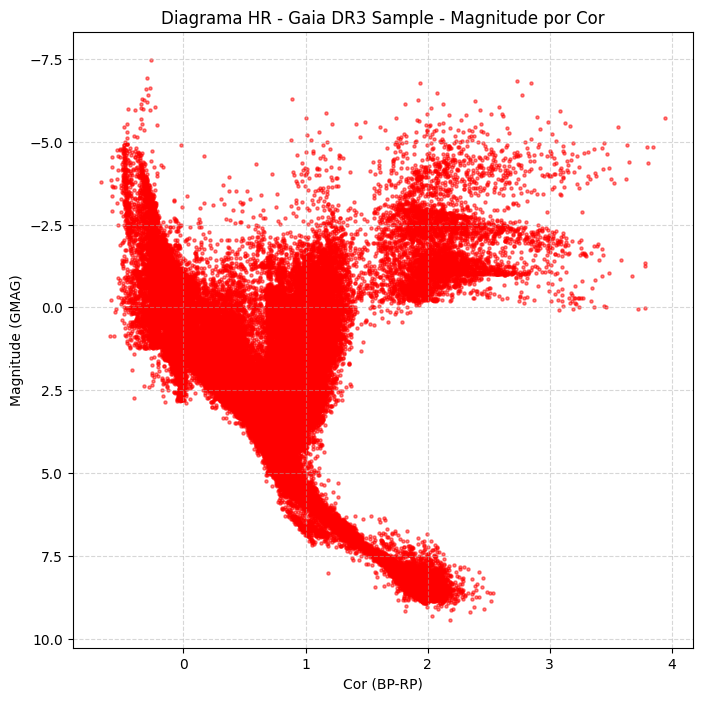

In [86]:
plt.figure(figsize=(8, 8))

plt.scatter(df_sample["BP-RP_corr"], df_sample["GMAG"],
            s=5, color='red', alpha=0.5)

plt.gca().invert_yaxis()

plt.xlabel("Cor (BP-RP)")
plt.ylabel("Magnitude (GMAG)")
plt.title("Diagrama HR - Gaia DR3 Sample - Magnitude por Cor")

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Testes

In [87]:
wd = df[df["PWD"] > 0.8]
print(wd["Rad"].describe())

count    5227.000000
mean        2.734931
std         2.561718
min         0.934500
25%         1.595850
50%         1.878300
75%         2.617700
max        47.708400
Name: Rad, dtype: float64


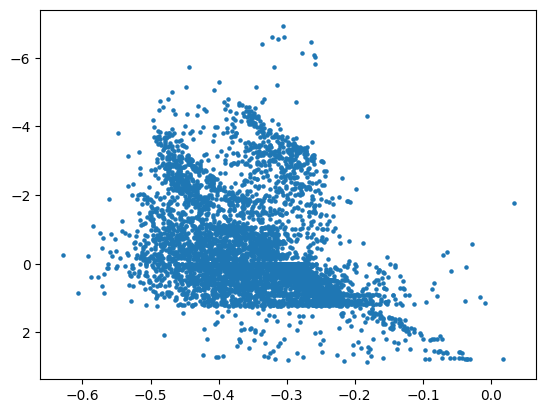

In [88]:
wd = df[df["PWD"] > 0.8]

plt.scatter(wd["BP-RP_corr"], wd["GMAG"], s=5)
plt.gca().invert_yaxis()
plt.show()

In [89]:
wd = df[df["PWD"] > 0.8]

print(wd["Plx"].describe())


count    5227.000000
mean        0.302287
std         0.233573
min         0.000200
25%         0.168200
50%         0.298500
75%         0.405400
max         6.816800
Name: Plx, dtype: float64


In [90]:
wd_near = df[
    (df["PWD"] > 0.8) &
    (df["Plx"] > 2)   # dentro de 500 pc
]

wd_near.describe()

,E(BP-RP),GMAG,Teff,Dist,Lum-Flame,Mass-Flame,Age-Flame,Rad,PWD,Pstar,PGal,Plx,e_Gmag,e_BPmag,e_RPmag,AG,BP-RP_corr
count,7.000000,7.000000,7.000000,7.000000,4.000000,4.000000,1.000,7.000000,7.000000,7.000000,7.0,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,0.269586,-1.639243,17848.040857,719.497157,910.431452,4.738250,0.201,4.663771,0.992601,0.000057,0.0,3.646143,0.004756,0.016004,0.013667,0.496429,-0.279982
std,0.318283,1.308792,4120.306963,1146.722438,1051.800222,1.185149,NaN,2.118655,0.018044,0.000017,0.0,1.769468,0.001919,0.017131,0.011814,0.584788,0.107145
min,0.000100,-3.390700,11680.873000,161.200900,186.441770,3.354000,0.201,2.052300,0.951775,0.000050,0.0,2.345500,0.002816,0.002978,0.003961,0.000100,-0.362939
25%,0.000650,-2.600800,15838.700500,222.237650,298.027752,4.141500,0.201,3.386900,0.998317,0.000050,0.0,2.473150,0.003149,0.004681,0.004585,0.001200,-0.351523
50%,0.201200,-1.645000,16494.170000,348.154600,497.645170,4.703000,0.201,3.685100,0.999950,0.000050,0.0,2.574000,0.004490,0.011618,0.010873,0.374100,-0.335242
75%,0.442400,-0.673700,20483.382000,385.453650,1110.048870,5.299750,0.201,5.969600,0.999950,0.000051,0.0,4.420200,0.005878,0.018150,0.018064,0.815150,-0.247030
max,0.799700,0.110000,24117.078000,3311.742000,2459.993700,6.193000,0.201,8.196000,0.999950,0.000095,0.0,6.816800,0.007932,0.051766,0.035535,1.468100,-0.064587


In [91]:
wd_phys = df[
    (df["PWD"] > 0.8) &
    (df["GMAG"] > 8) &
    (df["BP-RP_corr"] < 0.5) &
    (df["Plx"] > 2)
]

wd_phys.describe()

,E(BP-RP),GMAG,Teff,Dist,Lum-Flame,Mass-Flame,Age-Flame,Rad,PWD,Pstar,PGal,Plx,e_Gmag,e_BPmag,e_RPmag,AG,BP-RP_corr
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
print(df["Plx"].describe())


count    607296.000000
mean          1.397925
std           1.880071
min           0.000100
25%           0.318600
50%           0.845300
75%           1.585900
max          95.047700
Name: Plx, dtype: float64


In [93]:
print((df["Plx"] > 2).sum())
print((df["Plx"] > 5).sum())


111357
34557


In [94]:
wd_candidate = df[
    (df["Plx"] > 2) &
    (df["GMAG"] > 9) &
    (df["BP-RP_corr"] < 0.8)
]

wd_candidate.describe()

,E(BP-RP),GMAG,Teff,Dist,Lum-Flame,Mass-Flame,Age-Flame,Rad,PWD,Pstar,PGal,Plx,e_Gmag,e_BPmag,e_RPmag,AG,BP-RP_corr
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
print(df["GMAG"].describe())
# Isso explica a falta de anãs brancas reais no dataset, ele vai só até abaixo de 10 GMAG, ou seja, não pega estrelas com baixa luminosidade
# As estrelas que aparecem no diagrama nessa região são só ruído, já que estão com a luminosidade muito alta para serem anãs brancas

count    607296.000000
mean          2.190044
std           2.614755
min          -7.961700
25%           0.351900
50%           1.972000
75%           3.883300
max           9.963000
Name: GMAG, dtype: float64


# Utilizando dataset direto do servidor

In [ ]:
try:
    df_servidor_plx2 = pd.read_csv('dados_estrelas.csv')
except Exception:
    print("Erro ao ler arquivo. Reexecutando query...")
    from astroquery.gaia import Gaia

    query = """
    SELECT TOP 300000
        gs.source_id,
        gs.parallax,
        gs.phot_g_mean_mag,
        gs.bp_rp,
        ap.teff_gspphot,
        gs.phot_g_mean_mag + 5*LOG10(gs.parallax/1000) + 5 AS abs_mag
    FROM gaiadr3.gaia_source AS gs
    JOIN gaiadr3.astrophysical_parameters AS ap
    USING (source_id)
    WHERE gs.parallax > 2
    AND ap.teff_gspphot IS NOT NULL
    """
    job = Gaia.launch_job_async(query)
    df_servidor_plx2 = job.get_results().to_pandas()
    df_servidor_plx2.to_csv('dados_estrelas.csv')

In [103]:
df_servidor_plx2.describe()

,Unnamed: 0,source_id,parallax,phot_g_mean_mag,bp_rp,teff_gspphot,abs_mag
count,300000.000000,3.000000e+05,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,149999.500000,3.700099e+17,3.405916,16.125536,2.127780,4103.781641,8.583175
std,86602.684716,4.102788e+17,2.263256,2.397297,0.722697,963.533742,2.373888
min,0.000000,3.436113e+10,2.000008,2.904279,-0.343252,2584.621300,-3.461425
25%,74999.750000,8.745449e+16,2.304526,14.556023,1.515538,3404.531000,6.903339
50%,149999.500000,1.909898e+17,2.778709,16.830383,2.340469,3648.954850,9.301763
75%,224999.250000,4.991040e+17,3.750066,18.087014,2.693629,4619.976000,10.409133
max,299999.000000,1.574502e+18,392.752945,18.999958,4.717266,38816.120000,14.644616


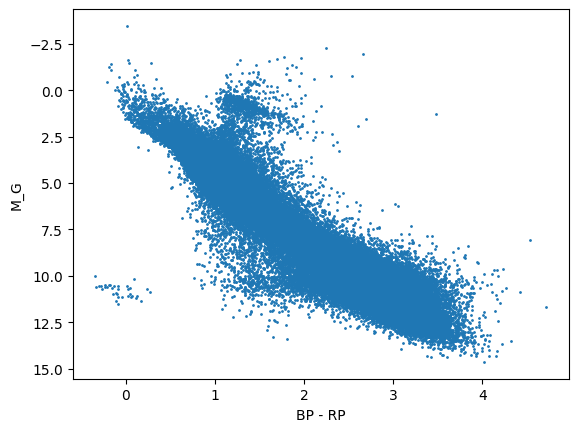

In [104]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(df_servidor_plx2["bp_rp"], df_servidor_plx2["abs_mag"], s=1)
plt.gca().invert_yaxis()
plt.xlabel("BP - RP")
plt.ylabel("M_G")
plt.show()

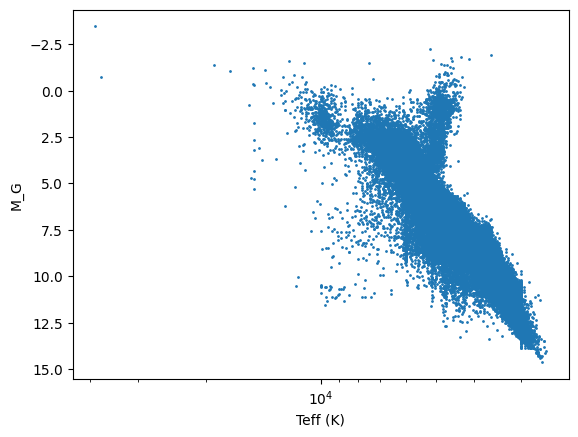

In [105]:
plt.figure()
plt.scatter(df_servidor_plx2["teff_gspphot"], df_servidor_plx2["abs_mag"], s=1)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()  # temperatura decresce para a direita
plt.xscale('log')
plt.xlabel("Teff (K)")
plt.ylabel("M_G")
plt.show()